In [1]:
#import base libraries
import pandas as pd
import numpy as np
import copy
import joblib
import cloudpickle

#Sklearn - Pipelines, Training
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#Model metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#misc
import warnings
warnings.filterwarnings('ignore')


# Get Data

In [61]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Dataset
keep_col = ['Date', 'Time', 'SpeciesName', 'LatitudeDD', 'LongitudeDD', 'LocationDescription', 
            'SeaState', 'WindSpeed', 'AnimalCountMeasure','Behaviour', 'Direction of Travel', 
            'SightingPlatform','Experience','Number of Animals Min', 'Location Accuracy']

# Import Dataset
data = pd.read_excel('/content/drive/MyDrive/Deep_Learning/Project/BCCSN_Sightings_Master.xlsx', 
                    parse_dates= ['Time'], usecols=keep_col)

#Check shape
print(data.shape)

#Print head
data.head()

# Get Final Training Data

Following steps from Data Cleaning (ie. missing data and dealing with unbalanced dataset)

In [ ]:
#Create definition to group target variables
def location_accuracy(df):
    """
    Input - dataframe
    Output - Newly Assigned Target Values for Location Accuracy
    Function groups Location Accuracy values into 3 subcategories
    """

    #cat_1 = list of location accuracies < 500 m
    #cat_2 = list of location accuracies 500 m - 2km
    #cat_3 = list of location accuracies > 2 km

    for x in cat_1:
        df.loc[df['Location Accuracy'].str.contains(x, na=False), 'Location Accuracy'] = '< 500m'
    for x in cat_2:
        df.loc[df['Location Accuracy'].str.contains(x, na=False), 'Location Accuracy'] = '500m-2km'
    for x in cat_3:
        df.loc[df['Location Accuracy'].str.contains(x, na=False), 'Location Accuracy'] = '> 2km'

    return df

In [3]:
#Check percentage of null in Location Accuracy
data['Location Accuracy'].isnull().sum()/len(data['Location Accuracy']) * 100

36.65047376268578

In [4]:
#Drop rows with null location accuracy
data = data.dropna(subset=['Location Accuracy'])

#print new shape
data.shape

(13171, 15)

In [5]:
#Replace blank strings with NaN
missing_values = ['-', '___']
data.LocationDescription = data['LocationDescription'].replace(missing_values, np.NaN)

In [ ]:
#Check percentage of null in location description
data['LocationDescription'].isnull().sum()/len(data.LocationDescription) * 100

In [ ]:
#Check location accuracy values
data['Location Accuracy'].value_counts()

In [8]:
#Fix Location Accuracy
data['Location Accuracy'] = data['Location Accuracy'].str.replace('w', 'W', regex = True)
data['Location Accuracy'] = data['Location Accuracy'].str.replace('WI', 'Wi', regex = True)
data['Location Accuracy'] = data['Location Accuracy'].str.replace('m ', 'm', regex = True)

In [ ]:
#Check updated location accuracy values
data['Location Accuracy'].value_counts()

In [10]:
#Apply limitation to reduce potential bias
#Code missing here

#First dropping Location Description and SightingDistance as too many missing values
data = data.drop(['LocationDescription'], axis = 1)

#print new shape
data.shape

(6171, 14)

In [ ]:
#Apply location_accuracy function
data = location_accuracy(data)

In [13]:
#Check new values
data['Location Accuracy'].value_counts()

< 500m      2748
500m-2km    2558
> 2km        865
Name: Location Accuracy, dtype: int64

In [14]:
#Remove Outlier found in EDA
data = data.drop(data[(data['LongitudeDD'] < -140) & (data['LatitudeDD'] > 50)].index)

#print final shape
data.shape

(6170, 14)

# Set-Up

In [16]:
#set variables and target
y = data['Location Accuracy']
X = data.drop('Location Accuracy', axis = 1)

In [17]:
#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state = 42)

# Trial - Baseline Log Regression

Trials of different functions and pipelines to see what works using Logistic Regression.

Note: I dropped NumberOfAnimals, this code for trials will not work with toy data

## Pipeline Creation

In [ ]:
#Define functions for Pipeline

#define nulls to nan function
def nulls_to_nan(df):
    """
    This function replaces all the "-" strings that represent null values
    And returns a dataframe with NaNs
    """
    missing_values = ['-', '___']
    df = df.replace(missing_values, np.NaN)
    return df

#define grammar function
def grammar(df):
    """
    This function will fix any letter casing issues in the text (Ie. Fixes categories)
    Returns a updated dataframe
    """
    #Fixing SeaState
    df['SeaState'] = df['SeaState'].str.replace('light', 'Light', regex = True)
    df['SeaState'] = df['SeaState'].str.replace(',Wind', 'Wind', regex = True)
    df['SeaState'] = df['SeaState'].str.replace('Light air,  small ripples', 'Light air, small ripples', regex = True)

    #Fixing WindSpeed
    df['WindSpeed'] = df['WindSpeed'].str.replace('5 - 6 kts', '4 - 6 kts', regex = True)
    df['WindSpeed'] = df['WindSpeed'].str.replace('2 - 3 kts', '1 - 3 kts', regex = True)
    df['WindSpeed'] = df['WindSpeed'].str.replace('3 - 3 kts', '1 - 3 kts', regex = True)
    df['WindSpeed'] = df['WindSpeed'].str.replace('18 - 21 kts', '17 - 21 kts', regex = True)

    #Fixing Direction of Travel
    df['Direction of Travel'] = df['Direction of Travel'].str.replace('Uknown', 'Unknown', regex = True)
    df['Direction of Travel'] = df['Direction of Travel'].str.replace('Unknown Travel Direction', 'Unknown', regex = True)

    #Fixing Sighting Platofrm
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('vessel', 'Vessel', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Verry', 'Ferry', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Moto Vessel', 'Motor Vessel', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Motorr', 'Motor', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('feet', 'ft', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Diving', 'Other', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Parks Canada', 'Other', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('wter', 'water', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('< 60 ft', '25 - 60 ft', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('> 25 ft', '25 - 60 ft', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('25-60ft', '25 - 60 ft', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('25-60', '25 - 60', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Vessel  25', 'Vessel 25', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('< 25 - 60', '< 25 ft', regex = True)

    #Fix Experience
    df['Experience'] = df['Experience'].str.replace('Recreational', 'Novice recreational observer', regex = True)
    
    return df

#define function that replaces NaNs
def fill_nans(df):
    """
    As simpleimputer returns an array and loses column names, this function will take it's place.
    Input is the dataframe
    This function will replace all NaNs (mean for numercial and most frequent for categorical)
    Returns a dataframe with no NaNs
    """
    #define your categorical features
    cat_cols = ['Time', 'SpeciesName', 'SeaState', 'Date', 'WindSpeed', 'AnimalCountMeasure', 'NumberOfAnimals',
                'Behaviour', 'Direction of Travel', 'SightingPlatform', 'Experience']

    #Replace NaN with most frequent value for Category columns
    for col in cat_cols:
        most_freq = df[col].mode().values[0]
        df[col].fillna(most_freq, inplace=True)
    
    #Replace missing values for numerical features
    num_cols = ['LatitudeDD', 'LongitudeDD']
    for num in num_cols:
        df[num].fillna(value=df[col].mode().values[0], inplace=True)

    return df

#define function to extract MinAnimals & MaxAnimals
def num_animal_log(df):
    """
    This function takes the NumberOfAnimals Column and splits the string into MinAnimals and MaxAnimals
    Returns dataframe with MinAnimals and MaxAnimals, and NumberOfAnimals dropped
    """
    
    #Create Empty Lists
    minanimals = []
    maxanimals = []
    for x in range(len(df.NumberOfAnimals)):
        #If integer/float append 0 in minanimal list
        if type(x) == int:
            minanimals.append(0) 
            maxanimals.append(x)
        elif type(x) == float:
            minanimals.append(0)
            maxanimals.append(x)
        #If str, split and append to minanimal & maxanimal
        else:
            new = x.split("~")
            minanimals.append(new[0]) 
            maxanimals.append(new[1]) 

    #Add new columns with variables
    #df['MinAnimal'] = minanimals
    df['MaxAnimal'] = maxanimals

    #Convert to type int
    #df.MinAnimal = df.MinAnimal.astype(int)
    df.MaxAnimal = df.MaxAnimal.astype(int)

    #Apply log
    #df.MinAnimal = np.nan_to_num(np.log(df.MinAnimal), neginf = 0)
    df.MaxAnimal = np.nan_to_num(np.log(df.MaxAnimal), neginf = 0)

    #Drop NumberOfAnimals
    df = df.drop(['NumberOfAnimals', 'Number of Animals Min'], axis = 1)

    return df
    
#define function to drop Number of Animals
def drop_numberanimals(df):
    df = df.drop(['NumberOfAnimals'], axis = 1)
    df['Number of Animals Min'] = np.nan_to_num(np.log(df['Number of Animals Min']), neginf = 0)
    return df

#define function to extract species category
def species_category(df):
    """
    This function uses the SpeciesName column in dataframe
    To create a new feature called Species Category
    Returns updated dataframe with SpeciesName Dropped
    """
    #Lists of Whales and Dolphins/Porpoise Species
    whales = ['Killer whale',"Grey whale", 'Humpback whale', 'Minke whale', 'Fin whale',  'Sperm whale', 
                'False killer whale', "Baird's beaked whale", "Cuvier's beaked whale", 'Sei whale', 
                'Blue whale', 'North Pacific right whale', 'Unidentified whale','Other rare species']

    d_p = ['Harbour porpoise',"Dall's porpoise", 'Pacific white-sided dolphin', "Risso's dolphin",
            'Northern right whale dolphin','Unidentified dolphin or porpoise']

    #Create empty list
    speciescategory = []

    #create for loop and appen to list
    for n in df.SpeciesName:
        if (n in whales) == True:
            speciescategory.append('Whales')
        elif (n in d_p) == True:
            speciescategory.append('Dolphins and Porpoises')
        else:
            speciescategory.append('Sea Turtle')
            
    #define new column
    df['SpeciesCategory'] = speciescategory

    #drop SpeciesName
    df = df.drop(['SpeciesName'], axis = 1)

    return df

#define extract behaviour function
def extract_behaviour(df):
    """
    This function takes in the dataframe and extracts unqiue features from the behaviour column
    And One hot encodes each variable
    Returns a dataframe with new behaviour columns and deleted behaviour column
    """
    #Create list if unique Behaviours
    behave = ['Fluking', 'Feeding', 'Porpoising', 'Spy-hopping', 'Slow Moving', 'Diving', 
            'Depredation', 'Travelling quickly', 'Bow-riding', 'Breaching', 'Fast moving']

    #Fix behaviour
    df.Behaviour = df.Behaviour.str.replace(' Fluking', 'Fluking', regex = True)
    df.Behaviour = df.Behaviour.str.replace('slow moving', 'Slow Moving', regex = True)
    df.Behaviour = df.Behaviour.str.replace('Slow moving', 'Slow Moving', regex = True)

    #turn behaviour column into list and split based on comma
    ls = list(df['Behaviour'].str.split(','))

    #create for loop do go through flat list (all unique values)
    for element in behave:
        #create column for each element
        df[element] = 0
        #enumerate through the column turned ls
        for index, l in enumerate(ls):
            #Assign False as 0 and True as 1 if element in ls
            df[element].iloc[index] = int(element in l)
    
    #Drop behaviour column
    df = df.drop(['Behaviour'], axis = 1)

    return df
    
#define date time function (hour, month, season)
def date_time(df):
    """
    This function takes in a dataframe and extracts features from date and time
    Returns new dataframe with extracted features and dropped SubDate and SubTime
    """
    #Create Month and Year columns
    df['Month'] = df['Date'].dt.month_name().str[:3]
    df['Year'] = df['Date'].dt.year
    # df['Year'] = df.Year.astype(str)

    #Create Season Column
    conditions = [(df['Month'] == 'Jan') | (df['Month'] == 'Feb') | (df['Month'] == 'Mar'), #winter
                (df['Month'] == 'Apr') | (df['Month'] == 'May') | (df['Month'] == 'Jun'), #spring
                (df['Month'] == 'Jul') | (df['Month'] == 'Aug') | (df['Month'] == 'Sep'), #summer
                (df['Month'] == 'Oct') | (df['Month'] == 'Nov') | (df['Month'] == 'Dec')] #autumn
    
    seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
    df['Season'] = np.select(conditions, seasons)

    #Create Hour Column
    item = df.Time.apply(lambda x: str(x)[:2])
    df['Hour'] = item

    times = [(df['Hour'] == '00') | (df['Hour'] == '01') | (df['Hour'] == '02') | (df['Hour'] == '03') | (df['Hour'] == '04') | (df['Hour'] == '05'),
            (df['Hour'] == '06') | (df['Hour'] == '07') | (df['Hour'] == '08') | (df['Hour'] == '09') | (df['Hour'] == '10') | (df['Hour'] == '11'),
            (df['Hour'] == '12') | (df['Hour'] == '13') | (df['Hour'] == '14') | (df['Hour'] == '15') | (df['Hour'] == '16') | (df['Hour'] == '17'),
            (df['Hour'] == '18') | (df['Hour'] == '19') | (df['Hour'] == '20') | (df['Hour'] == '21') | (df['Hour'] == '22') | (df['Hour'] == '23')]
    df['Hour'] = np.select(times, ['Early Morning', 'Morning', 'Afternoon', 'Night'])

    df = df.drop(['Date', 'Time'], axis = 1)

    return df


#define date time function (hour, month, season)
def date_time_2(df):
    """
    This function takes in a dataframe and extracts features from date and time
    Returns new dataframe with extracted features and dropped SubDate and SubTime
    """
    #Create Month and Year columns
    df['Month'] = df['Date'].dt.month_name().str[:3]
    df['Year'] = df['Date'].dt.year
    df['Year'] = df.Year.astype(str)

    #Create Season Column
    conditions = [(df['Month'] == 'Jan') | (df['Month'] == 'Feb') | (df['Month'] == 'Mar'), #winter
                (df['Month'] == 'Apr') | (df['Month'] == 'May') | (df['Month'] == 'Jun'), #spring
                (df['Month'] == 'Jul') | (df['Month'] == 'Aug') | (df['Month'] == 'Sep'), #summer
                (df['Month'] == 'Oct') | (df['Month'] == 'Nov') | (df['Month'] == 'Dec')] #autumn
    
    seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
    df['Season'] = np.select(conditions, seasons)

    #Create Hour Column
    item = df.Time.apply(lambda x: str(x)[:2])
    df['Hour'] = item

    df = df.drop(['Date', 'Time'], axis = 1)

    return df

#define function to extract seacatgory feature
def seacategory(df):
    """
    Function takes SeaState Column and categorizes them into a new column SeaCategory
    Returns new dataframe
    """
    crests = ['Wind felt on face;wave crests have glassy appearance', 'Crests begin to break;whitecaps start to form at 10 knots']
    moderate = ['Frequent whitecaps - sea to 3 ft (1 m)', 'Moderate waves form 4-5 ft (1.5-2.5 m);some spray carried']
    rough = ['Large waves 5-7 ft (2-3 m);more spray', 'Swell forms 8-10 ft (3-4 m);foam blown in streaks']
    dangerous = ['Moderately high waves to 16 ft (5 m);crests break into spindrift',
                'High waves to 20 ft (7 m);dense foam, visibility reduced']
    storm = ['Exceptionally high waves to 30 ft (9 m)','Waves to 35 ft (11 m);very limited visibility', 
            'Waves to 50 ft (15m);air filled with foam and spray']

    #Create empty list
    seacategory = []

    #create for loop and append to list
    for n in df.SeaState:
        if (n in crests) == True:
            seacategory.append('Crest')
        elif (n in moderate) == True:
            seacategory.append('Moderate')
        elif (n in rough) == True:
            seacategory.append('Rough')
        elif (n in dangerous) == True:
            seacategory.append('Dangerous')
        elif (n in storm) == True:
            seacategory.append('Storm')
        else:
            seacategory.append('Calm')
            
    #define new column
    df['SeaCategory'] = seacategory

    #drop windspeed
    df = df.drop(['SeaState'], axis = 1)

    return df

#define function to extract windcatgory feature
def windcategory(df):
    """
    Function takes WindSpeed Column and categorizes them into a new column WindCategory
    Returns new dataframe
    """
    light =['1 - 3 kts (Light Air)', '4 - 6 kts (Light Breeze)', '7 - 10 kts (Gentle Breeze)']
    breeze = ['11 - 16 kts (Moderate Breeze)', '17 - 21 kts (Fresh Breeze)', '22 - 27 kts (Strong Breeze)']
    gale = ['28 - 33 kts (Near Gale)', '34 - 40 kts (Gale)', '41 - 47 kts (Strong Gale)']
    storm = ['48 - 55 kts  (Storm)', '56 - 63 kts (Violent Storm)', '64+ kts (Hurricane)']

    #Create empty list
    windcategory = []

    #create for loop and appen to list
    for n in df.WindSpeed:
        if (n in light) == True:
            windcategory.append('Light')
        elif (n in breeze) == True:
            windcategory.append('Breeze')
        elif (n in gale) == True:
            windcategory.append('Gale')
        elif (n in storm) == True:
            windcategory.append('Storm')
        else:
            windcategory.append('Calm')
            
    #define new column
    df['WindCategory'] = windcategory

    #drop windspeed
    df = df.drop(['WindSpeed'], axis = 1)

    return df

#define function to transform lat and long
def transform_coord(df):
    """
    This function normalizes latitude and longitude.
    """
    df.LatitudeDD = df.LatitudeDD/100
    df.LongitudeDD = df.LongitudeDD/100

    return df

#Define function to delete behaviour column
def delete_behave(df):
    df = df.drop(['Behaviour'], axis = 1)
    return df
    
#Define object transformer class
class objectTransformer:
    """
    Class object transformer, takes in function to apply in preprocessing step of Pipeline
    """
    def __init__(self, func):
        self.func = func
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **fit_params):
        return self.func(X)


In [ ]:
#Test functions
test = copy.deepcopy(df)
test = nulls_to_nan(test)
test = grammar(test)
test = fill_nans(test)
test = drop_numberanimals(test)
test = species_category(test)
test = extract_behaviour(test)
test = date_time_2(test)
test = seacategory(test)
test = windcategory(test)
test = transform_coord(test)
test.dtypes

LatitudeDD               float64
LongitudeDD              float64
AnimalCountMeasure        object
Number of Animals Min    float64
Direction of Travel       object
SightingPlatform          object
Experience                object
Location Accuracy         object
SpeciesCategory           object
Fluking                    int64
Feeding                    int64
Porpoising                 int64
Spy-hopping                int64
Slow Moving                int64
Diving                     int64
Depredation                int64
Travelling quickly         int64
Bow-riding                 int64
Breaching                  int64
Fast moving                int64
Month                     object
Year                       int64
Season                    object
Hour                      object
SeaCategory               object
WindCategory              object
dtype: object

## PreProcessing

In [ ]:
# Create preprocessing
preprocessing = Pipeline([("fix_nulls", objectTransformer(nulls_to_nan)), #step 1 - Fix my NaNs (objectTransformer)
                        ('grammar', objectTransformer(grammar)), #Step 2 - Letter Casing
                        ('fill_na', objectTransformer(fill_nans)), #Step 3 - Fill in my nulls (column Transformer)
                        ('num_animal', objectTransformer(drop_numberanimals)), #Step 4 - Feature Engineering columns MinAnimals & MaxAnimals and using log
                        ('spcategory', objectTransformer(species_category)), #Step 5 - Feature Engineering column SpeciesCategory
                        ('behaviour', objectTransformer(extract_behaviour)), #Step 6 - Feature Engineering column Behvaiour
                        ('date_time', objectTransformer(date_time_2)), #Step 7 - Feature Engineering columns Hour, Month, Season
                        ('seacategory', objectTransformer(seacategory)), #Step 8 - Feature Engineering column SeaCategory
                        ('windcategory', objectTransformer(windcategory))]) #Step 9 - Feature Engineering column WindCategory

nobehave = Pipeline([("fix_nulls", objectTransformer(nulls_to_nan)), #step 1 - Fix my NaNs (objectTransformer)
                        ('grammar', objectTransformer(grammar)), #Step 2 - Letter Casing
                        ('fill_na', objectTransformer(fill_nans)), #Step 3 - Fill in my nulls (column Transformer)
                        ('num_animal', objectTransformer(drop_numberanimals)), #Step 4 - Feature Engineering columns MinAnimals & MaxAnimals and using log
                        ('spcategory', objectTransformer(species_category)), #Step 5 - Feature Engineering column SpeciesCategory
                        ('behaviour', objectTransformer(delete_behave)), #Step 6 - Delete Behvaiour
                        ('date_time', objectTransformer(date_time_2)), #Step 7 - Feature Engineering columns Hour, Month, Season
                        ('coordinates', objectTransformer(transform_coord)),
                        ('seacategory', objectTransformer(seacategory)), #Step 8 - Feature Engineering column SeaCategory
                        ('windcategory', objectTransformer(windcategory))]) #Step 9 - Feature Engineering column WindCategory


nobehave_cat = Pipeline([("fix_nulls", objectTransformer(nulls_to_nan)), #step 1 - Fix my NaNs (objectTransformer)
                        ('grammar', objectTransformer(grammar)), #Step 2 - Letter Casing
                        ('fill_na', objectTransformer(fill_nans)), #Step 3 - Fill in my nulls (column Transformer)
                        ('num_animal', objectTransformer(drop_numberanimals)), #Step 4 - Feature Engineering columns MinAnimals & MaxAnimals and using log
                        ('spcategory', objectTransformer(species_category)), #Step 5 - Feature Engineering column SpeciesCategory
                        ('behaviour', objectTransformer(delete_behave)), #Step 6 - Delete Behvaiour
                        ('date_time', objectTransformer(date_time_2)), #Step 7 - Feature Engineering columns Hour, Month, Season
                        ('coordinates', objectTransformer(transform_coord))])

transformcords = Pipeline([("fix_nulls", objectTransformer(nulls_to_nan)), #step 1 - Fix my NaNs (objectTransformer)
                        ('grammar', objectTransformer(grammar)), #Step 2 - Letter Casing
                        ('fill_na', objectTransformer(fill_nans)), #Step 3 - Fill in my nulls (column Transformer)
                        ('num_animal', objectTransformer(drop_numberanimals)), #Step 4 - Feature Engineering columns MinAnimals & MaxAnimals and using log
                        ('spcategory', objectTransformer(species_category)), #Step 5 - Feature Engineering column SpeciesCategory
                        ('behaviour', objectTransformer(extract_behaviour)), #Step 6 - Feature Engineering column Behvaiour
                        ('date_time', objectTransformer(date_time_2)), #Step 7 - Feature Engineering columns Hour, Month, Season
                        ('coordinates', objectTransformer(transform_coord)),
                        ('seacategory', objectTransformer(seacategory)), #Step 8 - Feature Engineering column SeaCategory
                        ('windcategory', objectTransformer(windcategory))]) #Step 9 - Feature Engineering column WindCategory


In [ ]:
#Define Pipelines to try

pipe_lr_1 = Pipeline([('preprocessing', preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore", sparse= False)),
                    ('scale', MaxAbsScaler()),
                    ('LR', LogisticRegression(random_state=42))])

pipe_lr_2 = Pipeline([('preprocessing', transformcords),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore", sparse= False)),
                    ('LR', LogisticRegression(random_state=42))])

pipe_lr_3 = Pipeline([('preprocessing', nobehave),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore", sparse= False)),
                    ('LR', LogisticRegression(random_state=42))])

pipe_lr_4 = Pipeline([('preprocessing', nobehave_cat),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore",sparse= False)),
                    ('LR', LogisticRegression(random_state=42))])


## Trials

In [ ]:
#fit pipes to check which is best
pipes = [pipe_lr_1,pipe_lr_2,pipe_lr_3,pipe_lr_4]

for pipe in pipes:
    pipe.fit(X_train, y_train)

#compare accuracies 

#make dictionary
pipe_dict = {0: 'Logistic Regression with MaxAbs', 1: 'Logistic Regression with transformed coord', 
            2: 'Logistic Regression with no behaviour', 3: 'Logistic Regression with no behaviour/category'}

#create for loop to find scores
for i, model in enumerate(pipes):
    print('{} Test Accuracy: {}'.format(pipe_dict[i], model.score(X_test,y_test)))

Logistic Regression with MaxAbs Test Accuracy: 0.5162074554294975
Logistic Regression with transformed coord Test Accuracy: 0.5162074554294975
Logistic Regression with no behaviour Test Accuracy: 0.5283630470016207
Logistic Regression with no behaviour/category Test Accuracy: 0.5283630470016207


In [ ]:
#Print classification report
print(classification_report(y_test, pipe_lr_1.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.50      0.50      0.50       511
      < 500m       0.54      0.68      0.60       550
       > 2km       0.24      0.05      0.08       173

    accuracy                           0.52      1234
   macro avg       0.43      0.41      0.39      1234
weighted avg       0.48      0.52      0.49      1234



In [ ]:
#Pipe lines with date_time 2 in preprocessing

#fit pipes to check which is best
pipes = [pipe_lr_1,pipe_lr_2,pipe_lr_3,pipe_lr_4]

for pipe in pipes:
    pipe.fit(X_train, y_train)

#compare accuracies of pipes
#make dictionary
pipe_dict = {0: 'Logistic Regression with MaxAbs', 1: 'Logistic Regression with transformed coord', 
            2: 'Logistic Regression with no behaviour', 3: 'Logistic Regression with no behaviour/category'}

#create for loop to find scores
for i, model in enumerate(pipes):
    print('{} Test Accuracy: {}'.format(pipe_dict[i], model.score(X_test,y_test)))

Logistic Regression with MaxAbs Test Accuracy: 0.5235008103727715
Logistic Regression with transformed coord Test Accuracy: 0.5235008103727715
Logistic Regression with no behaviour Test Accuracy: 0.5380875202593193
Logistic Regression with no behaviour/category Test Accuracy: 0.5348460291734197


In [ ]:
#Print classification report
print(classification_report(y_test, pipe_lr_3.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.52      0.53      0.52       511
      < 500m       0.56      0.70      0.62       550
       > 2km       0.29      0.05      0.08       173

    accuracy                           0.54      1234
   macro avg       0.46      0.43      0.41      1234
weighted avg       0.51      0.54      0.51      1234



In [ ]:
#Pipe lines with date time 2 and Year as string in preprocessing

#fit pipes to check which is best
pipes = [pipe_lr_1,pipe_lr_2,pipe_lr_3,pipe_lr_4]

for pipe in pipes:
    pipe.fit(X_train, y_train)

#compare accuracies of pipes
#make dictionary
pipe_dict = {0: 'Logistic Regression with MaxAbs', 1: 'Logistic Regression with transformed coord', 
            2: 'Logistic Regression with no behaviour', 3: 'Logistic Regression with no behaviour/category'}

#create for loop to find scores
for i, model in enumerate(pipes):
    print('{} Test Accuracy: {}'.format(pipe_dict[i], model.score(X_test,y_test)))

Logistic Regression with MaxAbs Test Accuracy: 0.5235008103727715
Logistic Regression with transformed coord Test Accuracy: 0.5235008103727715
Logistic Regression with no behaviour Test Accuracy: 0.5380875202593193
Logistic Regression with no behaviour/category Test Accuracy: 0.5348460291734197


In [ ]:
#Print classification report
print(classification_report(y_test, pipe_lr_4.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.52      0.53      0.52       511
      < 500m       0.55      0.70      0.62       550
       > 2km       0.27      0.04      0.07       173

    accuracy                           0.53      1234
   macro avg       0.45      0.42      0.40      1234
weighted avg       0.50      0.53      0.50      1234



In [ ]:
#Pipe lines with date time  without month in preprocessing

#fit pipes to check which is best
pipes = [pipe_lr_1,pipe_lr_2,pipe_lr_3,pipe_lr_4]

for pipe in pipes:
    pipe.fit(X_train, y_train)

#compare accuracies of pipes
#make dictionary
pipe_dict = {0: 'Logistic Regression with MaxAbs', 1: 'Logistic Regression with transformed coord', 
            2: 'Logistic Regression with no behaviour', 3: 'Logistic Regression with no behaviour/category'}

#create for loop to find scores
for i, model in enumerate(pipes):
    print('{} Test Accuracy: {}'.format(pipe_dict[i], model.score(X_test,y_test)))

Logistic Regression with MaxAbs Test Accuracy: 0.5162074554294975
Logistic Regression with transformed coord Test Accuracy: 0.5162074554294975
Logistic Regression with no behaviour Test Accuracy: 0.5178282009724473
Logistic Regression with no behaviour/category Test Accuracy: 0.513776337115073


In [ ]:
#Pipe line with delete NumberOfAnimals in preprocessing

#fit pipes to check which is best
pipes = [pipe_lr_1,pipe_lr_2,pipe_lr_3,pipe_lr_4]

for pipe in pipes:
    pipe.fit(X_train, y_train)

#compare accuracies of pipes
#make dictionary
pipe_dict = {0: 'Logistic Regression with MaxAbs', 1: 'Logistic Regression with transformed coord', 
            2: 'Logistic Regression with no behaviour', 3: 'Logistic Regression with no behaviour/category'}

#create for loop to find scores
for i, model in enumerate(pipes):
    print('{} Test Accuracy: {}'.format(pipe_dict[i], model.score(X_test,y_test)))

Logistic Regression with MaxAbs Test Accuracy: 0.5445705024311183
Logistic Regression with transformed coord Test Accuracy: 0.5445705024311183
Logistic Regression with no behaviour Test Accuracy: 0.5453808752025932
Logistic Regression with no behaviour/category Test Accuracy: 0.5316045380875203


In [ ]:
#Print classification report
print(classification_report(y_test, pipe_lr_1.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.53      0.52      0.52       511
      < 500m       0.57      0.73      0.64       550
       > 2km       0.21      0.03      0.06       173

    accuracy                           0.54      1234
   macro avg       0.44      0.43      0.41      1234
weighted avg       0.50      0.54      0.51      1234



In [ ]:
#Print classification report
print(classification_report(y_test, pipe_lr_3.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.54      0.52      0.53       511
      < 500m       0.56      0.73      0.64       550
       > 2km       0.13      0.02      0.03       173

    accuracy                           0.55      1234
   macro avg       0.41      0.42      0.40      1234
weighted avg       0.49      0.55      0.51      1234



# Models with HyperParams Grid Searches

## Final Functions

In [2]:
#Define functions for Pipeline

#define nulls to nan function
def nulls_to_nan(df):
    """
    This function replaces all the "-" strings that represent null values
    And returns a dataframe with NaNs
    """
    missing_values = ['-', '___']
    df = df.replace(missing_values, np.NaN)
    return df

#define grammar function
def grammar(df):
    """
    This function will fix any letter casing issues in the text (Ie. Fixes categories)
    Returns a updated dataframe
    """
    #Fixing SeaState
    df['SeaState'] = df['SeaState'].str.replace('light', 'Light', regex = True)
    df['SeaState'] = df['SeaState'].str.replace(',Wind', 'Wind', regex = True)
    df['SeaState'] = df['SeaState'].str.replace('Light air,  small ripples', 'Light air, small ripples', regex = True)

    #Fixing WindSpeed
    df['WindSpeed'] = df['WindSpeed'].str.replace('5 - 6 kts', '4 - 6 kts', regex = True)
    df['WindSpeed'] = df['WindSpeed'].str.replace('2 - 3 kts', '1 - 3 kts', regex = True)
    df['WindSpeed'] = df['WindSpeed'].str.replace('3 - 3 kts', '1 - 3 kts', regex = True)
    df['WindSpeed'] = df['WindSpeed'].str.replace('18 - 21 kts', '17 - 21 kts', regex = True)

    #Fixing Direction of Travel
    df['Direction of Travel'] = df['Direction of Travel'].str.replace('Uknown', 'Unknown', regex = True)
    df['Direction of Travel'] = df['Direction of Travel'].str.replace('Unknown Travel Direction', 'Unknown', regex = True)

    #Fixing Sighting Platofrm
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('vessel', 'Vessel', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Verry', 'Ferry', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Moto Vessel', 'Motor Vessel', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Motorr', 'Motor', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('feet', 'ft', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Diving', 'Other', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Parks Canada', 'Other', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('wter', 'water', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('< 60 ft', '25 - 60 ft', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('> 25 ft', '25 - 60 ft', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('25-60ft', '25 - 60 ft', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('25-60', '25 - 60', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('Vessel  25', 'Vessel 25', regex = True)
    df['SightingPlatform'] = df['SightingPlatform'].str.replace('< 25 - 60', '< 25 ft', regex = True)

    #Fix Experience
    df['Experience'] = df['Experience'].str.replace('Recreational', 'Novice recreational observer', regex = True)
    
    return df

#define function that replaces NaNs
def fill_nans(df):
    """
    As simpleimputer returns an array and loses column names, this function will take it's place.
    Input is the dataframe
    This function will replace all NaNs (mean for numercial and most frequent for categorical)
    Returns a dataframe with no NaNs
    """
    #define your categorical features
    cat_cols = ['Time', 'SpeciesName', 'SeaState', 'Date', 'WindSpeed', 'AnimalCountMeasure',
                'Behaviour', 'Direction of Travel', 'SightingPlatform', 'Experience']

    #Replace NaN with most frequent value for Category columns
    for col in cat_cols:
        most_freq = df[col].mode().values[0]
        df[col].fillna(most_freq, inplace=True)
    
    #Replace missing values for numerical features
    num_cols = ['LatitudeDD', 'LongitudeDD']
    for num in num_cols:
        df[num].fillna(value=df[col].mode().values[0], inplace=True)

    return df

#define function to log Number of Animals
def log_animals(df):
    df['Number of Animals Min'] = np.nan_to_num(np.log(df['Number of Animals Min']), neginf = 0)
    return df

#define function to extract species category
def species_category(df):
    """
    This function uses the SpeciesName column in dataframe
    To create a new feature called Species Category
    Returns updated dataframe with SpeciesName Dropped
    """
    #Lists of Whales and Dolphins/Porpoise Species
    whales = ['Killer whale',"Grey whale", 'Humpback whale', 'Minke whale', 'Fin whale',  'Sperm whale', 
                'False killer whale', "Baird's beaked whale", "Cuvier's beaked whale", 'Sei whale', 
                'Blue whale', 'North Pacific right whale', 'Unidentified whale','Other rare species']

    d_p = ['Harbour porpoise',"Dall's porpoise", 'Pacific white-sided dolphin', "Risso's dolphin",
            'Northern right whale dolphin','Unidentified dolphin or porpoise']

    #Create empty list
    speciescategory = []

    #create for loop and appen to list
    for n in df.SpeciesName:
        if (n in whales) == True:
            speciescategory.append('Whales')
        elif (n in d_p) == True:
            speciescategory.append('Dolphins and Porpoises')
        else:
            speciescategory.append('Sea Turtle')
            
    #define new column
    df['SpeciesCategory'] = speciescategory

    #drop SpeciesName
    df = df.drop(['SpeciesName'], axis = 1)

    return df

#define extract behaviour function
def extract_behaviour(df):
    """
    This function takes in the dataframe and extracts unqiue features from the behaviour column
    And One hot encodes each variable
    Returns a dataframe with new behaviour columns and deleted behaviour column
    """
    #Create list if unique Behaviours
    behave = ['Fluking', 'Feeding', 'Porpoising', 'Spy-hopping', 'Slow Moving', 'Diving', 
            'Depredation', 'Travelling quickly', 'Bow-riding', 'Breaching', 'Fast moving']

    #Fix behaviour
    df.Behaviour = df.Behaviour.str.replace(' Fluking', 'Fluking', regex = True)
    df.Behaviour = df.Behaviour.str.replace('slow moving', 'Slow Moving', regex = True)
    df.Behaviour = df.Behaviour.str.replace('Slow moving', 'Slow Moving', regex = True)

    #turn behaviour column into list and split based on comma
    ls = list(df['Behaviour'].str.split(','))

    #create for loop do go through flat list (all unique values)
    for element in behave:
        #create column for each element
        df[element] = 0
        #enumerate through the column turned ls
        for index, l in enumerate(ls):
            #Assign False as 0 and True as 1 if element in ls
            df[element].iloc[index] = int(element in l)
    
    #Drop behaviour column
    df = df.drop(['Behaviour'], axis = 1)

    return df

#define date time function (hour, month, season)
def date_time(df):
    """
    This function takes in a dataframe and extracts features from date and time
    Returns new dataframe with extracted features and dropped SubDate and SubTime
    """
    #Create Month and Year columns
    df['Month'] = df['Date'].dt.month_name().str[:3]
    df['Year'] = df['Date'].dt.year
    df['Year'] = df.Year.astype(str)

    #Create Season Column
    conditions = [(df['Month'] == 'Jan') | (df['Month'] == 'Feb') | (df['Month'] == 'Mar'), #winter
                (df['Month'] == 'Apr') | (df['Month'] == 'May') | (df['Month'] == 'Jun'), #spring
                (df['Month'] == 'Jul') | (df['Month'] == 'Aug') | (df['Month'] == 'Sep'), #summer
                (df['Month'] == 'Oct') | (df['Month'] == 'Nov') | (df['Month'] == 'Dec')] #autumn
    
    seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
    df['Season'] = np.select(conditions, seasons)

    #Create Hour Column
    item = df.Time.apply(lambda x: str(x)[:2])
    df['Hour'] = item

    df = df.drop(['Date', 'Time'], axis = 1)

    return df

#define function to extract seacatgory feature
def seacategory(df):
    """
    Function takes SeaState Column and categorizes them into a new column SeaCategory
    Returns new dataframe
    """
    crests = ['Wind felt on face;wave crests have glassy appearance', 'Crests begin to break;whitecaps start to form at 10 knots']
    moderate = ['Frequent whitecaps - sea to 3 ft (1 m)', 'Moderate waves form 4-5 ft (1.5-2.5 m);some spray carried']
    rough = ['Large waves 5-7 ft (2-3 m);more spray', 'Swell forms 8-10 ft (3-4 m);foam blown in streaks']
    dangerous = ['Moderately high waves to 16 ft (5 m);crests break into spindrift',
                'High waves to 20 ft (7 m);dense foam, visibility reduced']
    storm = ['Exceptionally high waves to 30 ft (9 m)','Waves to 35 ft (11 m);very limited visibility', 
            'Waves to 50 ft (15m);air filled with foam and spray']

    #Create empty list
    seacategory = []

    #create for loop and append to list
    for n in df.SeaState:
        if (n in crests) == True:
            seacategory.append('Crest')
        elif (n in moderate) == True:
            seacategory.append('Moderate')
        elif (n in rough) == True:
            seacategory.append('Rough')
        elif (n in dangerous) == True:
            seacategory.append('Dangerous')
        elif (n in storm) == True:
            seacategory.append('Storm')
        else:
            seacategory.append('Calm')
            
    #define new column
    df['SeaCategory'] = seacategory

    #drop windspeed
    df = df.drop(['SeaState'], axis = 1)

    return df

#define function to extract windcatgory feature
def windcategory(df):
    """
    Function takes WindSpeed Column and categorizes them into a new column WindCategory
    Returns new dataframe
    """
    light =['1 - 3 kts (Light Air)', '4 - 6 kts (Light Breeze)', '7 - 10 kts (Gentle Breeze)']
    breeze = ['11 - 16 kts (Moderate Breeze)', '17 - 21 kts (Fresh Breeze)', '22 - 27 kts (Strong Breeze)']
    gale = ['28 - 33 kts (Near Gale)', '34 - 40 kts (Gale)', '41 - 47 kts (Strong Gale)']
    storm = ['48 - 55 kts  (Storm)', '56 - 63 kts (Violent Storm)', '64+ kts (Hurricane)']

    #Create empty list
    windcategory = []

    #create for loop and appen to list
    for n in df.WindSpeed:
        if (n in light) == True:
            windcategory.append('Light')
        elif (n in breeze) == True:
            windcategory.append('Breeze')
        elif (n in gale) == True:
            windcategory.append('Gale')
        elif (n in storm) == True:
            windcategory.append('Storm')
        else:
            windcategory.append('Calm')
            
    #define new column
    df['WindCategory'] = windcategory

    #drop windspeed
    df = df.drop(['WindSpeed'], axis = 1)

    return df

#define function to transform lat and long
def transform_coord(df):
    """
    This function normalizes latitude and longitude.
    """
    df.LatitudeDD = df.LatitudeDD/100
    df.LongitudeDD = df.LongitudeDD/100

    return df

    
#Define object transformer class
class objectTransformer:
    """
    Class object transformer, takes in function to apply in preprocessing step of Pipeline
    """
    def __init__(self, func):
        self.func = func
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **fit_params):
        return self.func(X)


In [3]:
#Create definition to group target variables
def location_accuracy(df):
    """
    Input - dataframe
    Output - Newly Assigned Target Values for Location Accuracy
    Function groups Location Accuracy values into 3 subcategories
    """

    cat_1 = ['Within 5m', 'Within 50m', 'Within 100m', 'Within 200m', 'Within 500m']
    cat_2 = ['Within 1km', 'Within 2km']
    cat_3 = ['Within 5km', 'Within 10km','Within 20km', 'Within 25km', 'Within 50km', 'Within 100km']

    for x in cat_1:
        df.loc[df['Location Accuracy'].str.contains(x, na=False), 'Location Accuracy'] = '< 500m'
    for x in cat_2:
        df.loc[df['Location Accuracy'].str.contains(x, na=False), 'Location Accuracy'] = '500m-2km'
    for x in cat_3:
        df.loc[df['Location Accuracy'].str.contains(x, na=False), 'Location Accuracy'] = '> 2km'

    return df

#functions for plotting roc per clas
#Resource: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

## Final Preprocessing

In [24]:
#Create preprocessing
final_preprocessing = Pipeline([("fix_nulls", objectTransformer(nulls_to_nan)), #step 1 - Fix my NaNs (objectTransformer)
                        ('grammar', objectTransformer(grammar)), #Step 2 - Letter Casing
                        ('fill_na', objectTransformer(fill_nans)), #Step 3 - Fill in my nulls (column Transformer)
                        ('num_animal', objectTransformer(log_animals)), #Step 4 - Feature Engineering log Number of animals
                        ('spcategory', objectTransformer(species_category)), #Step 5 - Feature Engineering column SpeciesCategory
                        ('behaviour', objectTransformer(extract_behaviour)), #Step 6 - Feature Engineering column Behvaiour
                        ('date_time', objectTransformer(date_time)), #Step 7 - Feature Engineering columns Hour, Month, Season
                        ('seacategory', objectTransformer(seacategory)), #Step 8 - Feature Engineering column SeaCategory
                        ('windcategory', objectTransformer(windcategory))]) #Step 9 - Feature Engineering column WindCategory


## Model 1 - Log Regression

In [ ]:
#Create Final Log. Regression Pipeline
new_log = Pipeline([('preprocessing', final_preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore", sparse= False)),
                    ('scale', MaxAbsScaler()),
                    ('LR', LogisticRegression(random_state=42))])

#Fit new_log
new_log.fit(X_train, y_train)

In [ ]:
#find accruacy
y_prediction = new_log.predict(X_test)

# Calculate Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_prediction))

Accuracy: 0.5445705024311183


### Grid Search

In [ ]:
#Define parameters for grid searchs for each pipeline
lr_param_grid = [{'LR__penalty': ['l1','l2'],
                'LR__C': [0.01,0.1,1,10],
                'LR__solver':['saga', 'lbfgs']}]

#Make Grid Searches
lr_gs = GridSearchCV(estimator = new_log, param_grid = lr_param_grid, scoring = 'accuracy', cv = 3)

#Fit grid search
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('fix_nulls',
                                                         <__main__.objectTransformer object at 0x7f16dca7a310>),
                                                        ('grammar',
                                                         <__main__.objectTransformer object at 0x7f16dca7ae10>),
                                                        ('fill_na',
                                                         <__main__.objectTransformer object at 0x7f16da55ad50>),
                                                        ('num_animal',
                                                         <__main__.objectTransformer object at 0x7f16da55a450>),
                                                        ('spcategory',
                                                         <_...
                                                         <__m

In [ ]:
#Check score
print(f'Score: {lr_gs.score(X_test,y_test)}')
print(f'Best Params: {lr_gs.best_params_}')

Score: 0.5510534846029174
Best Params: {'LR__C': 0.1, 'LR__penalty': 'l1', 'LR__solver': 'saga'}


In [ ]:
#Print classification report
print(classification_report(y_test, lr_gs.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.54      0.47      0.51       511
      < 500m       0.56      0.80      0.65       550
       > 2km       0.00      0.00      0.00       173

    accuracy                           0.55      1234
   macro avg       0.37      0.42      0.39      1234
weighted avg       0.47      0.55      0.50      1234



In [ ]:
#Save model 
pickle.dump(lr_gs, open('/content/drive/MyDrive/Deep_Learning/Project/log_reg_model.pickle', 'wb'))

### Analysis

In [22]:
#load model
log_reg = pickle.load(open('Models/Location_Accuracy/log_reg_model.pickle', 'rb'))

In [23]:
#Predict X_test
y_prediction = log_reg.predict(X_test)

#Print measure scores
print(f"Accuracy: {accuracy_score(y_test, y_prediction)}")
print(f"F1 Score: {f1_score(y_test, y_prediction, average='micro')}")
print(f"Precision Score: {precision_score(y_test, y_prediction, average='micro')}")
print(f"Recall Score: {recall_score(y_test, y_prediction, average='micro')}")
print(f"ROC AUC Score: {roc_auc_score(y_test, log_reg.predict_proba(X_test),multi_class='ovr', average='macro')}")

#print full classification report
print(classification_report(y_test, y_prediction))

Accuracy: 0.5510534846029174
F1 Score: 0.5510534846029174
Precision Score: 0.5510534846029174
Recall Score: 0.5510534846029174
ROC AUC Score: 0.6744673319727638
              precision    recall  f1-score   support

    500m-2km       0.54      0.47      0.51       511
      < 500m       0.56      0.80      0.65       550
       > 2km       0.00      0.00      0.00       173

    accuracy                           0.55      1234
   macro avg       0.37      0.42      0.39      1234
weighted avg       0.47      0.55      0.50      1234



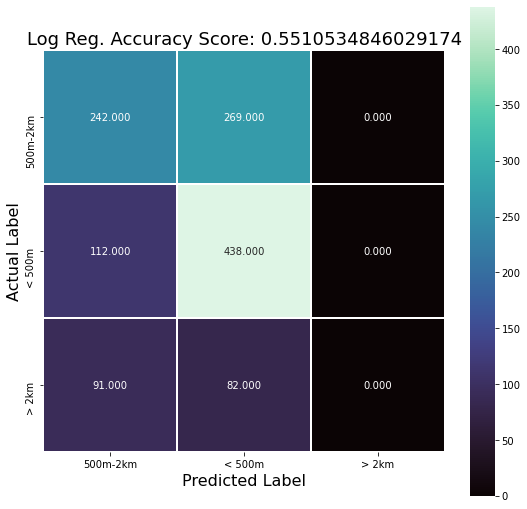

In [24]:
#Create a confusion matrix
matrix = confusion_matrix(y_test, y_prediction)

#Visualize the matrix with Seaborn

#Write title to display accuracy score
score = accuracy_score(y_test, y_prediction)
all_sample_title = 'Log Reg. Accuracy Score: {0}'.format(score)

#Set figure shape
plt.figure(figsize=(9,9))

#Use heatmap
p = sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=0.5, square=True, cmap="mako")

#Label the plot
lab = ['500m-2km', '< 500m', '> 2km']
p.set_ylabel('Actual Label', size=16)
p.set_xlabel('Predicted Label', size = 16)
p.set_xticklabels(lab)
p.set_yticklabels(lab)
p.set_title(all_sample_title, size = 18)


#save
fig = p.get_figure()
fig.savefig('Plots/Location_Accuracy/logreg_confusion.png')

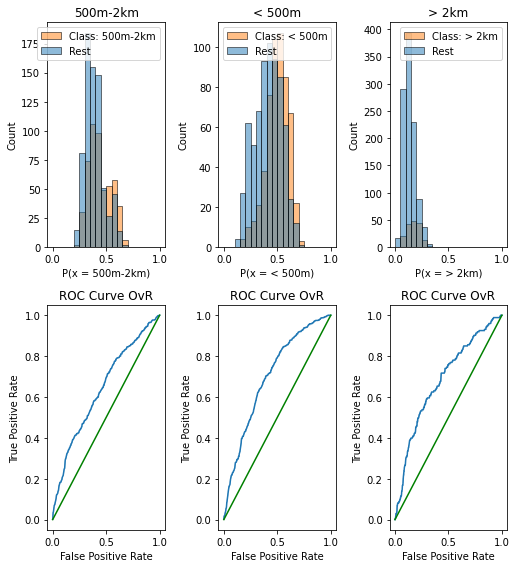

In [88]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
# reference: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = log_reg.classes_
roc_auc_ovr = {}
y_proba = log_reg.predict_proba(X_test)
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 5, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 5, i+6)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

## Model 2 - SVC

In [ ]:
#Set up pipeline
pipe_svc = Pipeline([('preprocessing', final_preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore",sparse= False)),
                    ('scale', MinMaxScaler()),
                     ('SVC', SVC(random_state=42))])

In [ ]:
#Fit training data
pipe_svc.fit(X_train, y_train)

In [ ]:
#Check score
print(f'Score: {pipe_svc.score(X_test,y_test)}')

Score: 0.5607779578606159


In [ ]:
#Print classification report
print(classification_report(y_test, pipe_svc.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.55      0.49      0.52       511
      < 500m       0.57      0.80      0.66       550
       > 2km       0.00      0.00      0.00       173

    accuracy                           0.56      1234
   macro avg       0.37      0.43      0.39      1234
weighted avg       0.48      0.56      0.51      1234



In [ ]:
#Save model 
pickle.dump(pipe_svc, open('/content/drive/MyDrive/Deep_Learning/Project/svc_model.pickle', 'wb'))

### Grid Search - Not Done

In [ ]:
#Define grid search params
svc_param_grid = [{'SVC__kernel': ['linear','poly', 'rbf', 'sigmoid'],
                'SVC__C': [0.001,0.01,0.1,1]}]

#Run grid search
svc_gs = GridSearchCV(estimator = pipe_svc, param_grid = svc_param_grid, scoring = 'accuracy', cv = 3)

#Fit training data
svc_gs.fit(X_train, y_train)

In [ ]:
#Check score
print(f'Score: {svc_gs.score(X_test,y_test)}')
print(f'Best Params: {svc_gs.best_params_}')

### Analysis

In [26]:
#load model
svc_model = pickle.load(open('Models/Location_Accuracy/svc_model.pickle', 'rb'))

In [ ]:
#Predict X_test
y_prediction = svc_model.predict(X_test)

#Print measure scores
print(f"Accuracy: {accuracy_score(y_test, y_prediction)}")
print(f"F1 Score: {f1_score(y_test, y_prediction, average='micro')}")
print(f"Precision Score: {precision_score(y_test, y_prediction, average='micro')}")
print(f"Recall Score: {recall_score(y_test, y_prediction, average='micro')}")
#Forgot to put probabilty=True for roc score

#print full classification report
print(classification_report(y_test, y_prediction))

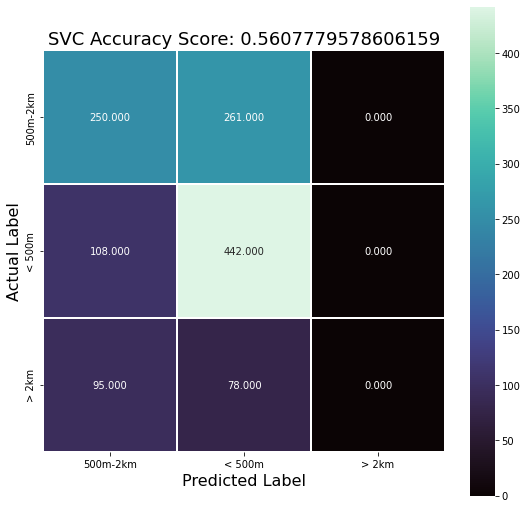

In [105]:
#Create a confusion matrix
matrix = confusion_matrix(y_test, y_prediction)

#Visualize the matrix with Seaborn

#Write title to display accuracy score
score = accuracy_score(y_test, y_prediction)
all_sample_title = 'SVC Accuracy Score: {0}'.format(score)

#Set figure shape
plt.figure(figsize=(9,9))

#Use heatmap
p = sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=0.5, square=True, cmap="mako")

#Label the plot
lab = ['500m-2km', '< 500m', '> 2km']
p.set_ylabel('Actual Label', size=16)
p.set_xlabel('Predicted Label', size = 16)
p.set_xticklabels(lab)
p.set_yticklabels(lab)
p.set_title(all_sample_title, size = 18)


#save
fig = p.get_figure()
fig.savefig('Plots/Location_Accuracy/svc_confusion.png')

## Model 3 - KNN

In [ ]:
#Set up pipeline
pipe_knn = Pipeline([('preprocessing', final_preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore",sparse= False)),
                    ('scale', MinMaxScaler()),
                    ('KNN', KNeighborsClassifier())])


In [ ]:
#Fit training data
pipe_knn.fit(X_train, y_train)

In [ ]:
#Check score
print(f'Score: {pipe_knn.score(X_test,y_test)}')

Score: 0.5235008103727715


In [ ]:
#Print classification report
print(classification_report(y_test, pipe_knn.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.49      0.60      0.54       511
      < 500m       0.58      0.60      0.59       550
       > 2km       0.33      0.07      0.11       173

    accuracy                           0.52      1234
   macro avg       0.47      0.42      0.41      1234
weighted avg       0.51      0.52      0.50      1234



In [ ]:
#Save model 
pickle.dump(pipe_knn, open('/content/drive/MyDrive/Deep_Learning/Project/knn_model.pickle', 'wb'))

### Analysis

In [30]:
#load model
knn_model = pickle.load(open('Models/Location_Accuracy/knn_model.pickle', 'rb'))

In [31]:
#Predict X_test
y_prediction = knn_model.predict(X_test)

#Print measure scores
print(f"Accuracy: {accuracy_score(y_test, y_prediction)}")
print(f"F1 Score: {f1_score(y_test, y_prediction, average='micro')}")
print(f"Precision Score: {precision_score(y_test, y_prediction, average='micro')}")
print(f"Recall Score: {recall_score(y_test, y_prediction, average='micro')}")
print(f"ROC AUC Score: {roc_auc_score(y_test, knn_model.predict_proba(X_test),multi_class='ovr', average='macro')}")

#print full classification report
print(classification_report(y_test, y_prediction))

Accuracy: 0.5235008103727715
F1 Score: 0.5235008103727715
Precision Score: 0.5235008103727715
Recall Score: 0.5235008103727715
ROC AUC Score: 0.6284064114033749
              precision    recall  f1-score   support

    500m-2km       0.49      0.60      0.54       511
      < 500m       0.58      0.60      0.59       550
       > 2km       0.33      0.07      0.11       173

    accuracy                           0.52      1234
   macro avg       0.47      0.42      0.41      1234
weighted avg       0.51      0.52      0.50      1234



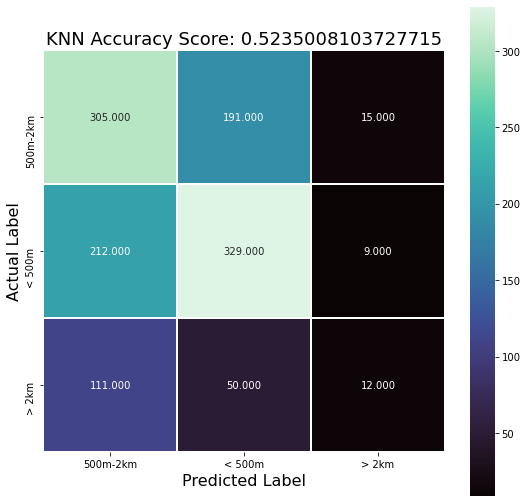

In [32]:
#Create a confusion matrix
matrix = confusion_matrix(y_test, y_prediction)

#Visualize the matrix with Seaborn

#Write title to display accuracy score
score = accuracy_score(y_test, y_prediction)
all_sample_title = 'KNN Accuracy Score: {0}'.format(score)

#Set figure shape
plt.figure(figsize=(9,9))

#Use heatmap
p = sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=0.5, square=True, cmap="mako")

#Label the plot
lab = ['500m-2km', '< 500m', '> 2km']
p.set_ylabel('Actual Label', size=16)
p.set_xlabel('Predicted Label', size = 16)
p.set_xticklabels(lab)
p.set_yticklabels(lab)
p.set_title(all_sample_title, size = 18)


#save
fig = p.get_figure()
fig.savefig('Plots/Location_Accuracy/knn_confusion.png')

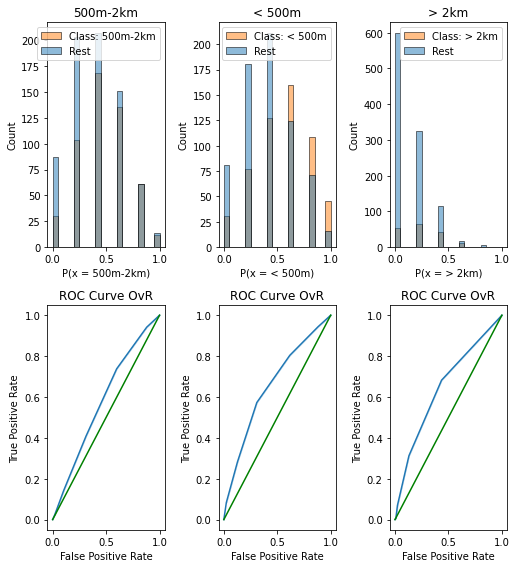

In [112]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
# reference: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = knn_model.classes_
roc_auc_ovr = {}
y_proba = knn_model.predict_proba(X_test)
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 5, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 5, i+6)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

## Model 4 - Random Forest

In [35]:
#Set up pipeline
pipe_rf = Pipeline([('preprocessing', final_preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore",sparse= False)),
                    ('RF',RandomForestClassifier(random_state=42))])


In [ ]:
#Fit Pipeline
pipe_rf.fit(X_train, y_train)

In [37]:
#Check score
print(f'Score: {pipe_rf.score(X_test,y_test)}')

Score: 0.5542949756888168


In [38]:
#Print classification report
print(classification_report(y_test, pipe_rf.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.53      0.55      0.54       511
      < 500m       0.58      0.73      0.64       550
       > 2km       0.33      0.01      0.01       173

    accuracy                           0.55      1234
   macro avg       0.48      0.43      0.40      1234
weighted avg       0.52      0.55      0.51      1234



In [39]:
#Save model 
pickle.dump(pipe_rf, open('Models/Location_Accuracy/randomforest_model.pickle', 'wb'))

### Grid Search

In [ ]:
#Define grid search params
rf_param_grid = [{'RF__n_estimators': [250,300,350],
                'RF__min_samples_leaf': [1,2],
                'RF__max_depth': [5,6,7,8],
                'RF__min_samples_split':[2,3,4]}]

#Run grid search
rfc_gs = GridSearchCV(estimator = pipe_rf, param_grid = rf_param_grid, scoring = 'accuracy', cv = 3)

#Fit training data
rfc_gs.fit(X_train, y_train)

In [ ]:
#Check score
print(f'Score: {rfc_gs.score(X_test,y_test)}')
print(f'Best Params: {rfc_gs.best_params_}')

Score: 0.5089141004862237
Best Params: {'RF__max_depth': 8, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 3, 'RF__n_estimators': 350}


### Analysis

In [40]:
#load model
rfc_model = pickle.load(open('Models/Location_Accuracy/randomforest_model.pickle', 'rb'))

In [41]:
#Predict X_test
y_prediction = rfc_model.predict(X_test)

#Print measure scores
print(f"Accuracy: {accuracy_score(y_test, y_prediction)}")
print(f"F1 Score: {f1_score(y_test, y_prediction, average='micro')}")
print(f"Precision Score: {precision_score(y_test, y_prediction, average='micro')}")
print(f"Recall Score: {recall_score(y_test, y_prediction, average='micro')}")
print(f"ROC AUC Score: {roc_auc_score(y_test, rfc_model.predict_proba(X_test),multi_class='ovr', average='macro')}")

#print full classification report
print(classification_report(y_test, y_prediction))

Accuracy: 0.5542949756888168
F1 Score: 0.5542949756888168
Precision Score: 0.5542949756888168
Recall Score: 0.5542949756888168
ROC AUC Score: 0.7039242819662452
              precision    recall  f1-score   support

    500m-2km       0.53      0.55      0.54       511
      < 500m       0.58      0.73      0.64       550
       > 2km       0.33      0.01      0.01       173

    accuracy                           0.55      1234
   macro avg       0.48      0.43      0.40      1234
weighted avg       0.52      0.55      0.51      1234



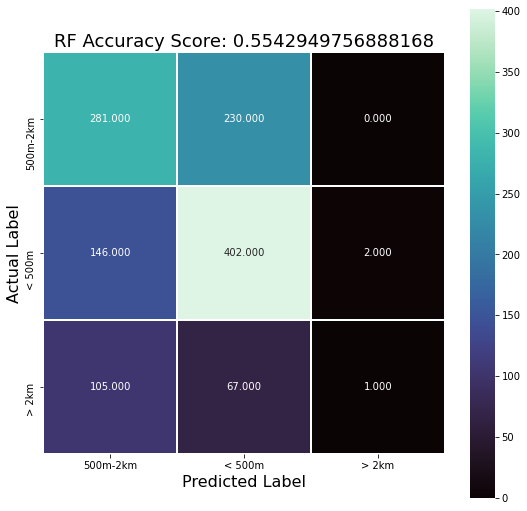

In [42]:
#Create a confusion matrix
matrix = confusion_matrix(y_test, y_prediction)

#Visualize the matrix with Seaborn

#Write title to display accuracy score
score = accuracy_score(y_test, y_prediction)
all_sample_title = 'RF Accuracy Score: {0}'.format(score)

#Set figure shape
plt.figure(figsize=(9,9))

#Use heatmap
p = sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=0.5, square=True, cmap="mako")

#Label the plot
lab = ['500m-2km', '< 500m', '> 2km']
p.set_ylabel('Actual Label', size=16)
p.set_xlabel('Predicted Label', size = 16)
p.set_xticklabels(lab)
p.set_yticklabels(lab)
p.set_title(all_sample_title, size = 18)


#save
fig = p.get_figure()
fig.savefig('Plots/Location_Accuracy/randomforest_confusion.png')

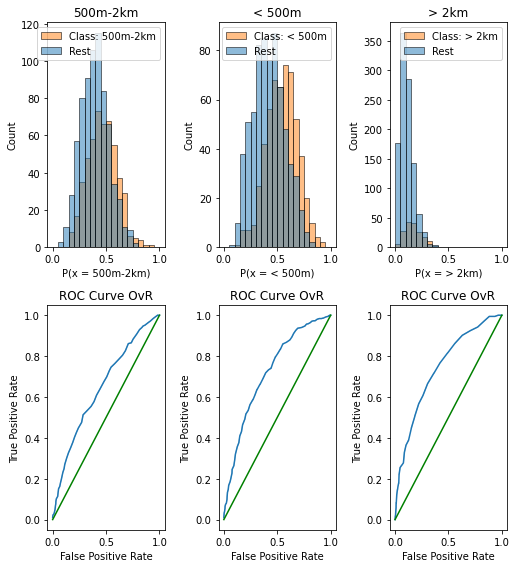

In [43]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
# reference: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = rfc_model.classes_
roc_auc_ovr = {}
y_proba = rfc_model.predict_proba(X_test)
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 5, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 5, i+6)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

## Model 5 - XGBoost

In [ ]:
#Set up pipeline
pipe_xgb = Pipeline([('preprocessing', final_preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore",sparse= False)),
                     ('XGB', XGBClassifier(tree_method = 'gpu_hist', random_state=42))])
#tree_method = 'gpu_hist'


In [ ]:
%%time
#Fit training data
pipe_xgb.fit(X_train, y_train)

In [ ]:
#Check score
print(f'Score: {pipe_xgb.score(X_test,y_test)}')

Score: 0.559967585089141


In [ ]:
#Print classification report
print(classification_report(y_test, pipe_xgb.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.55      0.49      0.52       511
      < 500m       0.57      0.80      0.66       550
       > 2km       0.33      0.01      0.02       173

    accuracy                           0.56      1234
   macro avg       0.48      0.43      0.40      1234
weighted avg       0.53      0.56      0.51      1234



### Grid Search

In [ ]:
xgb_param_grid = [{'XGB__objective': ['multi:softprob'],
                    'XGB__learning_rate': [0.03,0.01],
                   'XGB__max_depth': [6,7,8,9],
                    'XGB__n_estimators': [100,200,250,300,350]}]

#Run grid search
xgb_gs = GridSearchCV(estimator = pipe_xgb, param_grid = xgb_param_grid, scoring = 'accuracy', cv = 3)

#Fit training data
xgb_gs.fit(X_train, y_train)

#use before saving (pickle/json) if used GPU
# xgb_gs.set_params(tree_method = 'hist')

In [ ]:
# Compute metrics
print('Score: ', xgb_gs.best_score_)
print('Estimator: ', xgb_gs.best_estimator_)

Score:  0.5401123475164994
Estimator:  Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('fix_nulls',
                                  <__main__.objectTransformer object at 0x7fd448706e10>),
                                 ('grammar',
                                  <__main__.objectTransformer object at 0x7fd448706790>),
                                 ('fill_na',
                                  <__main__.objectTransformer object at 0x7fd448706090>),
                                 ('num_animal',
                                  <__main__.objectTransformer object at 0x7fd448706b90>),
                                 ('spcategory',
                                  <__main__.objectTransformer obj...
                                  <__main__.objectTransformer object at 0x7fd448706390>),
                                 ('seacategory',
                                  <__main__.objectTransformer object at 0x7fd448706a90>),
                                 ('w

In [ ]:
#Print classification report
print(classification_report(y_test, xgb_gs.predict(X_test)))

              precision    recall  f1-score   support

    500m-2km       0.56      0.51      0.53       511
      < 500m       0.58      0.76      0.66       550
       > 2km       0.43      0.09      0.15       173

    accuracy                           0.56      1234
   macro avg       0.52      0.46      0.45      1234
weighted avg       0.55      0.56      0.54      1234



The grid search resulted in a lower accuracy, but overall the precision, recall and f1-score increased. Had to also rerun xgboost on own computer, (pickle file was not loading)

In [ ]:
#Set up pipeline
final_xgb = Pipeline([('preprocessing', final_preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore",sparse= False)),
                     ('XGB', XGBClassifier(learning_rate = 0.01, max_depth = 9,
                                           n_estimators = 250, objective='multi:softprob',
                                           random_state=42))])

#Fit training data
final_xgb.fit(X_train, y_train)

In [45]:
#find y_prediction
y_pred = final_xgb.predict(X_test)

#Check scores
print(f'Accuracy: {accuracy_score(y_test,y_pred)}')

#Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.5640194489465153
              precision    recall  f1-score   support

    500m-2km       0.56      0.52      0.54       511
      < 500m       0.58      0.75      0.65       550
       > 2km       0.40      0.09      0.15       173

    accuracy                           0.56      1234
   macro avg       0.51      0.46      0.45      1234
weighted avg       0.54      0.56      0.54      1234



In [46]:
#Save model 
pickle.dump(final_xgb, open('Models/Location_Accuracy/xgboost_model.pickle', 'wb'))

### Analysis

In [47]:
#load model
xgb_model = pickle.load(open('Models/Location_Accuracy/xgboost_model.pickle', 'rb'))

In [48]:
#Predict X_test
y_prediction = xgb_model.predict(X_test)

#Print measure scores
print(f"Accuracy: {accuracy_score(y_test, y_prediction)}")
print(f"F1 Score: {f1_score(y_test, y_prediction, average='micro')}")
print(f"Precision Score: {precision_score(y_test, y_prediction, average='micro')}")
print(f"Recall Score: {recall_score(y_test, y_prediction, average='micro')}")
print(f"ROC AUC Score: {roc_auc_score(y_test, xgb_model.predict_proba(X_test),multi_class='ovr', average='macro')}")

#print full classification report
print(classification_report(y_test, y_prediction))

Accuracy: 0.5640194489465153
F1 Score: 0.5640194489465153
Precision Score: 0.5640194489465153
Recall Score: 0.5640194489465153
ROC AUC Score: 0.7060565985901116
              precision    recall  f1-score   support

    500m-2km       0.56      0.52      0.54       511
      < 500m       0.58      0.75      0.65       550
       > 2km       0.40      0.09      0.15       173

    accuracy                           0.56      1234
   macro avg       0.51      0.46      0.45      1234
weighted avg       0.54      0.56      0.54      1234



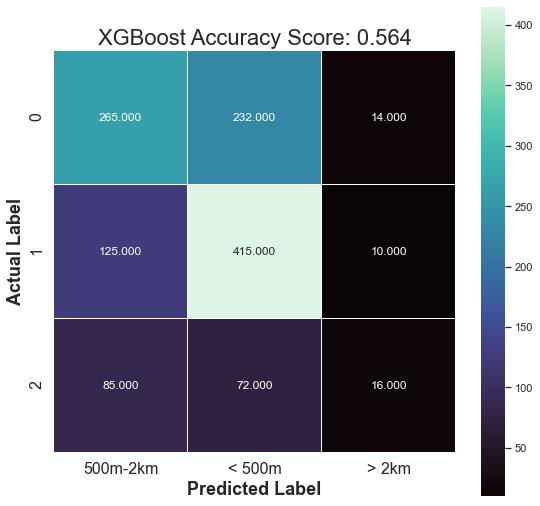

In [226]:
#Create a confusion matrix
matrix = confusion_matrix(y_test, y_prediction)

#Visualize the matrix with Seaborn

#Write title to display accuracy score
score = accuracy_score(y_test, y_prediction)
all_sample_title = 'XGBoost Accuracy Score: {0}'.format(round(score,3))

#Set figure shape
plt.figure(figsize=(9,9))

#Use heatmap
p = sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=0.5, square=True, cmap="mako")

#Label the plot
lab = ['500m-2km', '< 500m', '> 2km']
p.set_ylabel('Actual Label', size=18, weight ='bold')
p.set_xlabel('Predicted Label', size = 18, weight ='bold')
p.set_xticklabels(lab)
p.tick_params(labelsize=16)
p.set_title(all_sample_title, size = 22)


#save
fig = p.get_figure()
fig.savefig('Plots/Location_Accuracy/xgb_confusion.png')

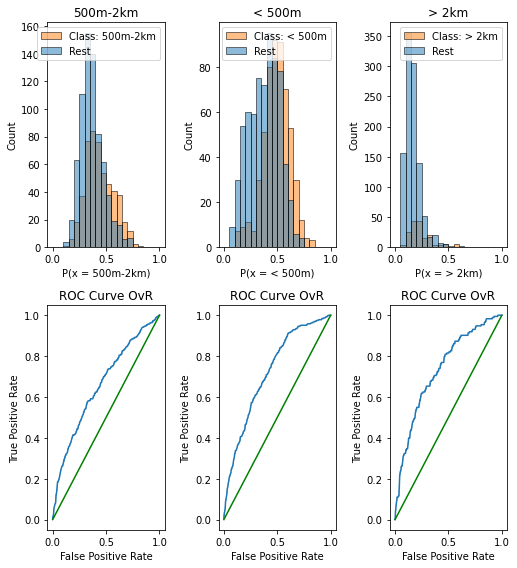

In [50]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
# reference: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = xgb_model.classes_
roc_auc_ovr = {}
y_proba = xgb_model.predict_proba(X_test)
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 5, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 5, i+6)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

# XGBoost with Sighting Distance

XGBoost is able to handle missing values. So I will try including the Sighting Distance with NaN values

## Prep Data

Apply the same code to this model

In [4]:
# Import Dataset
keep_col2 = ['Date', 'Time', 'SpeciesName', 'LatitudeDD', 'LongitudeDD', 'LocationDescription', 
             'SeaState', 'WindSpeed', 'AnimalCountMeasure', 'Behaviour', 'Direction of Travel', 
             'SightingPlatform','Experience','Number of Animals Min', 'Location Accuracy', 
             'SightingDistance']

# Import Dataset 
data2 = pd.read_excel('OceanWise Info/BCCSN_Sightings_Master.xlsx', parse_dates= ['Time'], usecols=keep_col2)

#Check shape
print(data2.shape)

(20791, 16)


In [5]:
#Check percentage of null in Location Accuracy
data2['Location Accuracy'].isnull().sum()/len(data2['Location Accuracy']) * 100

36.65047376268578

In [6]:
#Drop rows with null location accuracy
data2 = data2.dropna(subset=['Location Accuracy'])


In [7]:
#Replace blank strings with NaN
missing_values = ['-', '___']
data2.LocationDescription = data2['LocationDescription'].replace(missing_values, np.NaN)

In [8]:
#Check percentage of null in location description
data2['LocationDescription'].isnull().sum()/len(data2.LocationDescription) * 100

61.01283122010478

In [9]:
#Fix Location Accuracy
data2['Location Accuracy'] = data2['Location Accuracy'].str.replace('w', 'W', regex = True)
data2['Location Accuracy'] = data2['Location Accuracy'].str.replace('WI', 'Wi', regex = True)
data2['Location Accuracy'] = data2['Location Accuracy'].str.replace('m ', 'm', regex = True)

In [ ]:
#Check updated location accuracy values
data2['Location Accuracy'].value_counts()

In [11]:
#Apply limitation
#Code removed here

#First dropping Location Description and SightingDistance as too many missing values
data2 = data2.drop(['LocationDescription'], axis = 1)

#print new shape
data2.shape

(6171, 15)

In [12]:
#Apply location_accuracy function
data2 = location_accuracy(data2)

In [13]:
#Check new values
data2['Location Accuracy'].value_counts()

< 500m      2748
500m-2km    2558
> 2km        865
Name: Location Accuracy, dtype: int64

In [14]:
#Remove Outlier found in EDA
data2 = data2.drop(data2[(data2['LongitudeDD'] < -140) & (data2['LatitudeDD'] > 50)].index)

#print final shape
data2.shape

(6170, 15)

In [ ]:
#check Sighting Distance values
data2.SightingDistance.value_counts()

In [16]:
#Clean Sighting Distance
data2.loc[data2['SightingDistance'].str.contains('< 10m', na=False), 'SightingDistance'] = '10-25m'
data2.loc[data2['SightingDistance'].str.contains('10-25m', na=False), 'SightingDistance'] = '10-25m'
data2.loc[data2['SightingDistance'].str.contains('25-100m', na=False), 'SightingDistance'] = '25-100m'
data2.loc[data2['SightingDistance'].str.contains('100m', na=False), 'SightingDistance'] = '100-300m'
data2.loc[data2['SightingDistance'].str.contains('100-300m', na=False), 'SightingDistance'] = '100-300m'
data2.loc[data2['SightingDistance'].str.contains('300-1000m', na=False), 'SightingDistance'] = '300-1000m'
data2.loc[data2['SightingDistance'].str.contains('> 1km', na=False), 'SightingDistance'] = '> 1km'
data2.loc[data2['SightingDistance'].str.contains('>1km', na=False), 'SightingDistance'] = '> 1km'

In [17]:
#Replace blank strings with NaN
missing_values = ['-', '___', None]
data2.SightingDistance = data2['SightingDistance'].replace(missing_values, 'NULL')

In [18]:
#check Sighting Distance values
data2.SightingDistance.value_counts()

NULL         2785
100-300m     1737
300-1000m     873
> 1km         568
10-25m        207
Name: SightingDistance, dtype: int64

## Set-Up

In [21]:
#set variables and target
y2 = data2['Location Accuracy']
X2 = data2.drop('Location Accuracy', axis = 1)

In [22]:
#Split data into training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, stratify = y2, random_state = 42)

## Build Model

In [ ]:
#Set up pipeline
#if want to use GPU: tree_method = 'gpu_hist'
pipe_xgb2 = Pipeline([('preprocessing', final_preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore",sparse= False)),
                     ('XGB', XGBClassifier(random_state=42))])


In [ ]:
%%time
#Fit training data
pipe_xgb2.fit(X_train2, y_train2)

In [ ]:
#Check score
print(f'Score: {pipe_xgb2.score(X_test2,y_test2)}')

#Print classification report
print(classification_report(y_test2, pipe_xgb2.predict(X_test2)))

Score: 0.5623987034035657
              precision    recall  f1-score   support

    500m-2km       0.52      0.59      0.55       511
      < 500m       0.60      0.70      0.64       550
       > 2km       0.69      0.05      0.10       173

    accuracy                           0.56      1234
   macro avg       0.60      0.45      0.43      1234
weighted avg       0.58      0.56      0.53      1234



#### Grid Search

In [ ]:
#define grid search params
xgb_param_grid = [{'XGB__objective': ['multi:softprob'],
                    'XGB__learning_rate': [0.03,0.01,0.1],
                    'XGB__max_depth': [6,7,8,9],
                    'XGB__n_estimators': [100,200,300]}]

#Run grid search
xgb_gs2 = GridSearchCV(estimator = pipe_xgb2, param_grid = xgb_param_grid, scoring = 'accuracy', cv = 3)

#Fit training data
xgb_gs2.fit(X_train2, y_train2)

In [ ]:
# Compute metrics
print('Score: ', xgb_gs2.best_score_)
print('Estimator: ', xgb_gs2.best_estimator_)

#Print classification report
print(classification_report(y_test2, xgb_gs2.predict(X_test2)))

Score:  0.5688775466237269
Estimator:  Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('fix_nulls',
                                  <__main__.objectTransformer object at 0x7f16db0d27d0>),
                                 ('grammar',
                                  <__main__.objectTransformer object at 0x7f16d613eb10>),
                                 ('fill_na',
                                  <__main__.objectTransformer object at 0x7f16db9f9b10>),
                                 ('num_animal',
                                  <__main__.objectTransformer object at 0x7f16db9f9550>),
                                 ('spcategory',
                                  <__main__.objectTransformer obj...
                                  <__main__.objectTransformer object at 0x7f16db9f9210>),
                                 ('seacategory',
                                  <__main__.objectTransformer object at 0x7f16db9f9d10>),
                                 ('w

## Final Model

In [ ]:
#Build Final
final_xgb2 = Pipeline([('preprocessing', final_preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore",sparse= False)),
                     ('XGB', XGBClassifier(learning_rate=0.03, max_depth=6,
                               n_estimators=300, objective='multi:softprob',
                               random_state=42))])

#define grid search params for just n_estimators
xgb_param_grid2 = [{'XGB__n_estimators': [250,300,350,400]}]

#Run grid search
xgb_gs2 = GridSearchCV(estimator = final_xgb2, param_grid = xgb_param_grid2, 
                       scoring = 'accuracy', cv = 3)

#Fit training data
xgb_gs2.fit(X_train2, y_train2)

In [ ]:
# Compute metrics
print('Score: ', xgb_gs2.best_score_)
print('Estimator: ', xgb_gs2.best_estimator_)

#Print classification report
print(classification_report(y_test2, xgb_gs2.predict(X_test2)))

In [25]:
#Had to rerun final model on own computer due to corrupt pickle file

#Build Final
final_xgb2 = Pipeline([('preprocessing', final_preprocessing),
                    ('one_hot', OneHotEncoder(handle_unknown = "ignore",sparse= False)),
                     ('XGB', XGBClassifier(learning_rate=0.03, max_depth=6,
                               n_estimators=250, objective='multi:softprob',
                              random_state=42))])

#Fit training data
final_xgb2.fit(X_train2, y_train2)

[21:30:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('fix_nulls',
                                  <__main__.objectTransformer object at 0x11eed6460>),
                                 ('grammar',
                                  <__main__.objectTransformer object at 0x11eed6400>),
                                 ('fill_na',
                                  <__main__.objectTransformer object at 0x11eed6c40>),
                                 ('num_animal',
                                  <__main__.objectTransformer object at 0x11eed6490>),
                                 ('spcategory',
                                  <__main__.objectTransformer object at 0x11eed...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_co

In [26]:
#Check score
print(f'Score: {final_xgb2.score(X_test2,y_test2)}')
print(f"Accuracy: {accuracy_score(y_test2, final_xgb2.predict(X_test2))}")

#Print classification report
print(classification_report(y_test2, final_xgb2.predict(X_test2)))

Score: 0.5834683954619124
Accuracy: 0.5834683954619124
              precision    recall  f1-score   support

    500m-2km       0.56      0.62      0.59       511
      < 500m       0.62      0.69      0.65       550
       > 2km       0.48      0.12      0.19       173

    accuracy                           0.58      1234
   macro avg       0.55      0.48      0.48      1234
weighted avg       0.57      0.58      0.56      1234



In [27]:
#Save model 
joblib.dump(final_xgb2, 'Models/Location_Accuracy/xgb_sightdis_model_gs.joblib')

['Models/Location_Accuracy/xgb_sightdis_model_gs.joblib']

## Analysis

In [27]:
#load model
# xgb_sd_model = pickle.load(open('Models/Location_Accuracy/xgb_sightdis_model_gs.pickle', 'rb'))
xgb_sd_model = joblib.load('Models/Location_Accuracy/xgb_sightdis_model_gs.joblib')

In [28]:
#Predict X_test
y_prediction2 = xgb_sd_model.predict(X_test2)

#Print measure scores
print(f"Accuracy: {accuracy_score(y_test2, y_prediction2)}")
print(f"F1 Score: {f1_score(y_test2, y_prediction2, average='micro')}")
print(f"Precision Score: {precision_score(y_test2, y_prediction2, average='micro')}")
print(f"Recall Score: {recall_score(y_test2, y_prediction2, average='micro')}")
print(f"ROC AUC Score: {roc_auc_score(y_test2, xgb_sd_model.predict_proba(X_test2),multi_class='ovr', average='macro')}")

#print full classification report
print(classification_report(y_test2, y_prediction2))

Accuracy: 0.5834683954619124
F1 Score: 0.5834683954619124
Precision Score: 0.5834683954619124
Recall Score: 0.5834683954619124
ROC AUC Score: 0.7255986889021129
              precision    recall  f1-score   support

    500m-2km       0.56      0.62      0.59       511
      < 500m       0.62      0.69      0.65       550
       > 2km       0.48      0.12      0.19       173

    accuracy                           0.58      1234
   macro avg       0.55      0.48      0.48      1234
weighted avg       0.57      0.58      0.56      1234



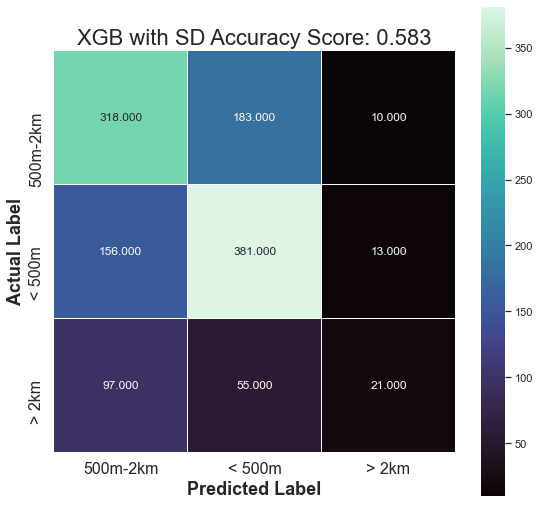

In [225]:
#Create a confusion matrix
matrix = confusion_matrix(y_test2, y_prediction2)

#Visualize the matrix with Seaborn

#Write title to display accuracy score
score = accuracy_score(y_test2, y_prediction2)
all_sample_title = 'XGB with SD Accuracy Score: {0}'.format(round(score,3))

#Set figure shape
plt.figure(figsize=(9,9))

#Use heatmap
p = sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=0.5, square=True, cmap="mako")

#Label the plot
lab = ['500m-2km', '< 500m', '> 2km']
p.set_ylabel('Actual Label', size=18, weight ='bold')
p.set_xlabel('Predicted Label', size = 18, weight ='bold')
p.set_xticklabels(lab)
p.tick_params(labelsize=16)
p.set_yticklabels(lab)
p.set_title(all_sample_title, size = 22)


#save
fig = p.get_figure()
fig.savefig('Plots/Location_Accuracy/xgb_withSD_confusion.png')

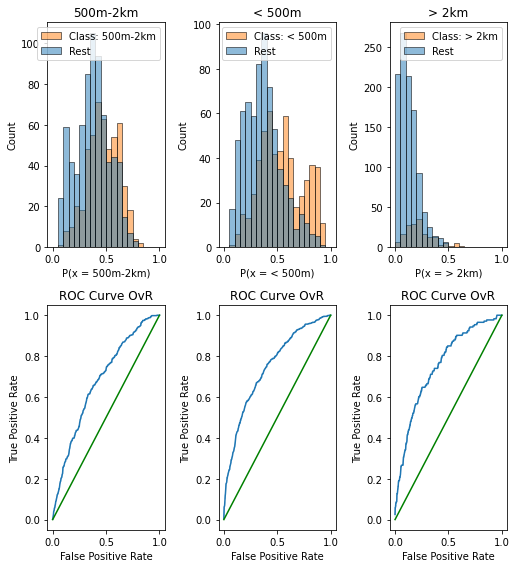

In [220]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
# reference: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
classes = xgb_sd_model.classes_
roc_auc_ovr = {}
y_proba = xgb_sd_model.predict_proba(X_test2)
for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test2.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test2]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 5, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 5, i+6)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

# Comparison Plot

In [221]:
#Create variables
accuracy = [55.1, 55.4, 56.4, 58.4]
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

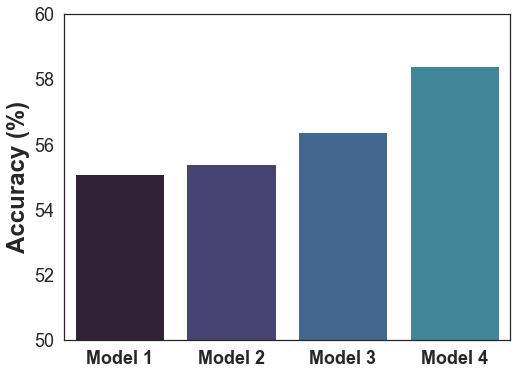

In [240]:
#plot to compare accuracies
fig = plt.figure(figsize=[8,6])
sns.set_palette("mako")
sns.barplot(x = models, y = accuracy)
sns.set_theme(style="white")
plt.xlabel(None)
plt.ylabel('Accuracy (%)', size = 24, weight = 'bold')
plt.yticks(fontsize=18)
plt.xticks(weight='bold', fontsize=18)
plt.ylim([50,60])
plt.show()

#Save
fig.savefig('Plots/Loca_Acc_model_accuracies.png')

In [30]:
#Create F1 Score diction for comparing Model 3 and 4
f1_dic = {
        'Location Accuracy': ['< 500m', '500m - 2km', '> 2km', '< 500m', '500m - 2km', '> 2km'],
        'F1_Scores':[0.65,0.54,0.15, 0.65, 0.69, 0.19],
        'Model': ['Model 3', 'Model 3', 'Model 3', 'Model 4', 'Model 4', 'Model 4']
}

#Create DataFrame
f1_score_df = pd.DataFrame(f1_dic)
f1_score_df

,Location Accuracy,F1_Scores,Model
0,< 500m,0.65,Model 3
1,500m - 2km,0.54,Model 3
2,> 2km,0.15,Model 3
3,< 500m,0.65,Model 4
4,500m - 2km,0.69,Model 4
5,> 2km,0.19,Model 4


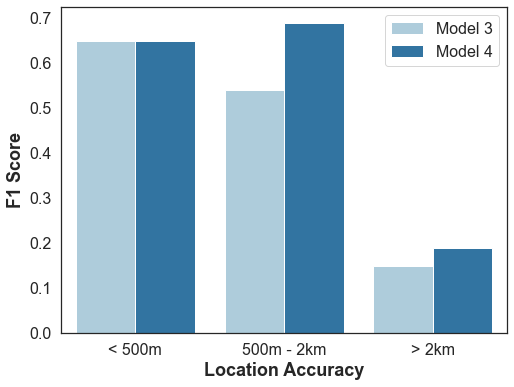

In [31]:
#Compare F1 Score comparisons
fig = plt.figure(figsize=[8,6])
sns.barplot(data = f1_score_df, x = 'Location Accuracy', y='F1_Scores', hue='Model')
sns.set_theme(style="white")
sns.set_palette("Paired")
plt.xlabel('Location Accuracy', size = 18, weight='bold')
plt.ylabel('F1 Score', size = 18, weight = 'bold')
plt.tick_params(labelsize=16)
plt.legend(loc = 'upper right', title = None, fontsize=16)
plt.show()

#save
fig.savefig('Plots/Location_Accuracy/Model_Comparison.png')